# Libs

In [1]:
import os
import time
import json
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import tensorflow.keras.backend as K
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Dense, Reshape, Activation, Dropout, Flatten
from tensorflow.keras.layers import Embedding, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import he_normal, constant
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical, normalize

# Load Data

In [2]:
avi_train_seg = np.load('../Data/avi_train_seg.npy')
trj_train_seg = np.load('../Data/trj_train_seg.npy')
lane_functions = np.load('../Data/lane_functions.npy')

In [3]:
num_lanes = lane_functions.sum(axis=1)
lane_functions = pd.DataFrame(lane_functions,columns=['through','left','right',
                                                      'thr_left','thr_right','u_turn'])
lane_functions['linkIdx'] = np.arange(1,25)
lane_functions['num_lanes'] = num_lanes

# WGAN

In [171]:
def wasserstein(y_true, y_pred):
    return -K.mean(y_true * y_pred)

In [166]:
def build_generator(noise_dim, target_dim):
    gen_input = Input(shape=noise_dim, name="generator_input")
    
    def build_dense(gen_input, units):
        h = Dense(units=units,use_bias=True,activation=None,
                  kernel_initializer=he_normal(),
                  bias_initializer=constant(0.1),
                  kernel_regularizer=l2())(gen_input)
        h = BatchNormalization()(h)
        h = LeakyReLU(0.1)(h)
        return h
    
    o = build_dense(gen_input, units=100)
    o = build_dense(o, units=target_dim)
    generator = Model(inputs=gen_input, outputs=o, name='generator')
    
    return generator

In [167]:
def build_discriminator(target_dim):
    disc_input = Input(shape=target_dim, name='discriminator_input')
    
    def build_dense(gen_input, units):
        h = Dense(units=units,use_bias=True,activation=None,
                  kernel_initializer=he_normal(),
                  bias_initializer=constant(0.1),
                  kernel_regularizer=l2())(gen_input)
        h = BatchNormalization()(h)
        h = LeakyReLU(0.1)(h)
        return h
    
    o = build_dense(disc_input, units=100)
    o = build_dense(o, units=1)
    discriminator = Model(inputs=disc_input, outputs=o, name='discriminator')
    
    return discriminator

In [154]:
def build_wgan(generator, discriminator, noise_dim, target_dim):
    noise_input = Input(shape=noise_dim, name="noise_input")
    generated_sample = generator(noise_input)
    wgan_output = discriminator(generated_sample)
    wgan = Model(inputs=[noise_input],
                 outputs=[wgan_output],
                 name="WGAN")
    return wgan

In [155]:
def get_batch(X, batch_size):
    while True:
        idx = np.random.choice(X.shape[0], batch_size, replace=False)
        yield X[idx]

In [156]:
def sample_noise(batch_size, noise_dim, mean, scale):
    return np.random.normal(loc=mean, scale=scale, size=(batch_size, noise_dim))

In [172]:
def train_wgan(noise_dim, target_dim, lr_g, lr_d,
               num_epochs, num_batch_per_epoch, disc_iterations,
               clip_lb, clip_ub,
               X_real, batch_size, mean, scale):

    # build model
    generator = build_generator(noise_dim, target_dim)
    discriminator = build_discriminator(target_dim)
    wgan = build_wgan(generator, discriminator, noise_dim, target_dim)

    # define optimizer
    optimizer_gen = Adam(lr_g)
    optimizer_disc = Adam(lr_d)

    # model compile
    generator.compile(loss='mse', optimizer=optimizer_gen)
    discriminator.trainable = False
    wgan.compile(loss=wasserstein, optimizer=optimizer_gen)
    discriminator.trainable = True
    discriminator.compile(loss=wasserstein, optimizer=optimizer_disc)

    # training
    sp = time.time()
    log = []
    gen_iterations = 0
    for i in range(num_epochs):
        batch_counter = 0
        while batch_counter < num_batch_per_epoch:
            
            # *************************************
            # train discriminator
            # ************************************* 
            
            if gen_iterations < 25:# or gen_iterations % 500 == 0:
                disc_iterations = 100
            else:
                disc_iterations = disc_iterations
            
            list_disc_loss_real = []
            list_disc_loss_gen = []

            for disc_it in range(disc_iterations):

                # Clip discriminator weights
                for l in discriminator.layers:
                    weights = l.get_weights()
                    weights = [np.clip(w, clip_lb, clip_ub) for w in weights]
                    l.set_weights(weights)

                X_real_batch = next(get_batch(X_real, batch_size))
                noise_input = sample_noise(batch_size, noise_dim, mean, scale)

                X_disc_gen = generator.predict(noise_input, batch_size=batch_size)
                X_disc_real = X_real_batch[:batch_size]

                disc_loss_real = discriminator.train_on_batch(X_disc_real,
                                                              np.ones(X_disc_real.shape[0]))
                disc_loss_gen = discriminator.train_on_batch(X_disc_gen,
                                                             -np.ones(X_disc_gen.shape[0]))

                list_disc_loss_real.append(disc_loss_real)
                list_disc_loss_gen.append(disc_loss_gen)
                
                if batch_counter % 500 == 0:
                    print("[Epoch-{:d}][Batch-{:d}][Iteration-{:d}][Discriminator loss] g: {:.3f} | d: {:3f}".format(
                        i, batch_counter, disc_it, np.mean(disc_loss_gen), np.mean(disc_loss_real)
                    ))
            
            # *************************************
            # train generator
            # *************************************
            
            X_gen = sample_noise(int(2 * batch_size), noise_dim, mean, scale)
            discriminator.trainable = False
            gen_loss = wgan.train_on_batch(X_gen, np.ones(X_gen.shape[0]))
            if batch_counter % 500 == 0:
                print("[Epoch-{:d}][Batch-{:d}][Generator loss] {:.3f} [Duration] {:.1f} sec.\n".format(
                    i, batch_counter, np.mean(gen_loss), time.time() - sp))
            discriminator.trainable = True
            
            log.append([np.mean(disc_loss_real), np.mean(disc_loss_gen), np.mean(gen_loss)])
            pd.DataFrame(log,columns=['disc_loss_real',
                                      'disc_loss_fake',
                                      'gen_loss']).to_csv('./wgan_train/log.csv',index=None)
            gen_iterations += 1
            batch_counter += 1
            
    return generator, discriminator

In [ ]:
noise_dim = 5
target_dim = X_train.shape[-1]
batch_size = 32
num_batch_per_epoch = int(X_train.shape[0] / batch_size)

generator, discriminator = train_wgan(noise_dim=5, target_dim=target_dim,
                                      lr_g=3e-4, lr_d=3e-4, num_epochs=10,
                                      num_batch_per_epoch=num_batch_per_epoch,
                                      disc_iterations=5, clip_ub=0.1, clip_lb=-0.1,
                                      X_real=X_train.values, batch_size=batch_size,
                                      mean=0.0, scale=0.5)

In [133]:
logger = pd.read_csv('./log.csv')

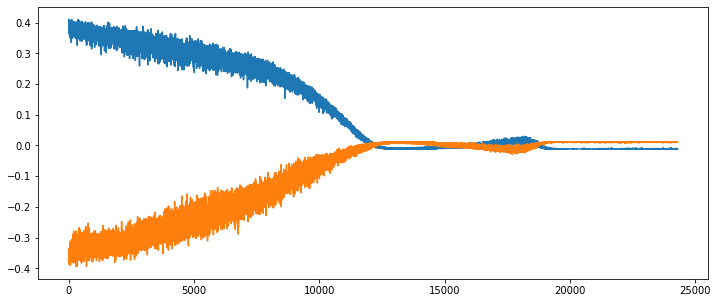

In [134]:
plt.figure(figsize=(12,5))
plt.plot(logger.iloc[:,0])
plt.plot(logger.iloc[:,1])